# Import necessary libraries

In [1]:
from saltup.ai.classification.datagenerator import ClassificationDataloader, keras_ClassificationDataGenerator, pytorch_ClassificationDataGenerator
from saltup.ai.base_dataformat.base_datagen import *
from saltup.ai.object_detection.utils.metrics import Metric
from saltup.ai.training.callbacks import BaseCallback, CallbackContext
from saltup.ai.training.app_callbacks import ClassificationEvaluationsCallback
from saltup.ai.nn_model import NeuralNetworkModel
from saltup.ai.classification.evaluate import evaluate_model
from saltup.utils.jupyter_notebook import generate_notebook_id, save_current_notebook
from saltup.ai.training.train import training
from saltup.utils.data.image.image_utils import Image, ColorMode


import os
import zipfile
import numpy as np
from glob import glob
from datetime import datetime
import tensorflow as tf

/home/mark/anaconda3/envs/testlib/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-07-23 12:42:18.713433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 12:42:18.725260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753267338.740386  564011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alr

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs.zip


# Unzip the file using Python
with zipfile.ZipFile("cats_and_dogs.zip", "r") as zip_ref:
    extract_dir = "dataset"
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    zip_ref.extractall(extract_dir)
    
    os.remove("cats_and_dogs.zip")

--2025-07-23 12:42:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.209.59, 216.58.209.59, 216.58.204.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.209.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  65,43M  4,47MB/s    in 28s     

2025-07-23 12:42:54 (2,35 MB/s) - ‘cats_and_dogs.zip’ saved [68606236/68606236]



In [3]:
NUM_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 1
EPOCH_CALLBACK_EVERY = 1
INPUT_SIZE = (128, 128)
TRAIN_DATA_DIR = './dataset/cats_and_dogs_filtered/train'
TEST_DATA_DIR = './dataset/cats_and_dogs_filtered/validation'
CLASS_NAMES = ['cats', 'dogs']
CLASS_DICTIONARY = {'cats': 0, 'dogs': 1}

# Load a pre-trained model or define your own architecture

In [4]:


def build_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model(input_shape=(128, 128, 3), num_classes=NUM_CLASSES)


2025-07-23 12:45:22.383633: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Data generator

In [5]:
def preprocess(image:np.ndarray, target_size:tuple) -> np.ndarray:
    """Preprocess the image by resizing and normalizing."""
    temp_image = Image(image)
    temp_image = temp_image.resize(target_size)
    img = temp_image.get_data()
    img = img / 255.0  # Normalize pixel values between [0, 1]
    return img.astype(np.float32)  # Ensure the image is float32 for ONNX inference

In [6]:
transformed_img = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5)
   ])

In [7]:
train_dataloader = ClassificationDataloader(
    source=TRAIN_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

test_dataloader = ClassificationDataloader(
    source=TEST_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

In [8]:

# Create Classification Data Generator
train_gen = keras_ClassificationDataGenerator(
    dataloader=train_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=transformed_img
)


test_gen = keras_ClassificationDataGenerator(
    dataloader=test_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=None  # no augmentation
)

images, labels = next(iter(train_gen))
print(images.shape)
print(labels.shape)

(32, 128, 128, 3)
(32, 2)


Example image shape: 63
0.8875077


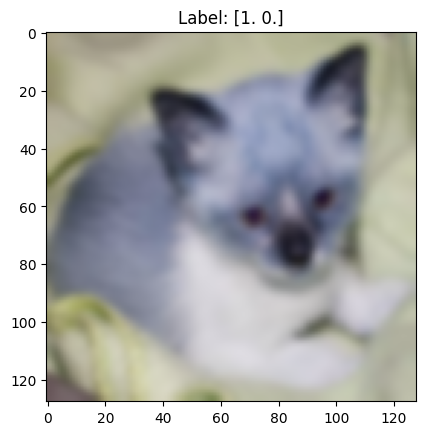

In [9]:
example_image = train_gen[0][0][9]
example_label = train_gen[0][1][9]
print(f"Example image shape: {len(train_gen)}")
#plot image
import matplotlib.pyplot as plt
def plot_image(image, label):
    plt.imshow(image.squeeze())
    plt.title(f"Label: {label}")
    #plt.axis('off')
    plt.show()
   
print(np.max(example_image))
plot_image(example_image, example_label)

# Training

In [14]:
todaytime = datetime.now()
output_dir = "./training_outputs"
current_tests_folder_name = "train_{}".format(todaytime.strftime("%d-%m-%Y_%H-%M-%S"))
current_output_dir = os.path.join(output_dir, current_tests_folder_name)
if not os.path.exists(current_output_dir):
    os.makedirs(current_output_dir)

initial_learning_rate = 0.001
decay_steps = 1000
keras_optimizer =  tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps))
keras_loss = tf.keras.losses.CategoricalCrossentropy()



custom_cb = ClassificationEvaluationsCallback(
    datagen=test_gen,
    end_of_train_datagen=test_gen,
    every_epoch=EPOCH_CALLBACK_EVERY,
    output_file=os.path.join(current_output_dir, "classification_evaluations.txt"),
    class_names=CLASS_NAMES

)

kfold_parameters = {'enable':True, 'split':[0.2, 0.2, 0.2, 0.2, 0.2]}
model_output_name = "tiny_model"

results_dict = training(
        train_gen,
        model=model,
        loss_function=keras_loss,
        optimizer=keras_optimizer,
        epochs=EPOCHS,
        output_dir=current_output_dir,
        validation_split=[0.2, 0.8],
        kfold_param =kfold_parameters,
        model_output_name = model_output_name,
        training_callback=[custom_cb])


--- Fold 1 ---
Number of training samples: {'cats': 799, 'dogs': 801}
Number of validation samples: {'cats': 201, 'dogs': 199}

--- Model training ---


/home/mark/anaconda3/envs/testlib/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.6549


                          METRICS SUMMARY FOR EPOCH 1                           
Best model epoch: 1 | Best loss: 0.6465 | Best val_loss: 0.6566
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:04<00:00,  7.29it/s, accuracy=0.458, fn=372, fp=372, tp=628]


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4197    
dogs               | 0.4911    

Overall:
True Positives (TP):      628
False Positives (FP):     372
Overall Accuracy:         0.4577
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.6545 - val_loss: 0.6566



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s, accuracy=0.458, fn=372, fp=372, tp=628]


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4197    
dogs               | 0.4911    

Overall:
True Positives (TP):      628
False Positives (FP):     372
Overall Accuracy:         0.4577
Saved trained model at ./training_outputs/train_23-07-2025_12-49-02/k_0/saved_models/tiny_model_best.keras 

--- Fold 2 ---
Number of training samples: {'cats': 800, 'dogs': 800}
Number of validation samples: {'cats': 200, 'dogs': 200}

--- Model training ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5977


                          METRICS SUMMARY FOR EPOCH 1                           
Best model epoch: 1 | Best loss: 0.6107 | Best val_loss: 0.5685
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s, accuracy=0.502, fn=332, fp=332, tp=668]


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4985    
dogs               | 0.5045    

Overall:
True Positives (TP):      668
False Positives (FP):     332
Overall Accuracy:         0.5015
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 0.5980 - val_loss: 0.5685



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, accuracy=0.502, fn=332, fp=332, tp=668]


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4985    
dogs               | 0.5045    

Overall:
True Positives (TP):      668
False Positives (FP):     332
Overall Accuracy:         0.5015
Saved trained model at ./training_outputs/train_23-07-2025_12-49-02/k_1/saved_models/tiny_model_best.keras 

--- Fold 3 ---
Number of training samples: {'cats': 797, 'dogs': 803}
Number of validation samples: {'cats': 203, 'dogs': 197}

--- Model training ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.5790


                          METRICS SUMMARY FOR EPOCH 1                           
Best model epoch: 1 | Best loss: 0.5898 | Best val_loss: 0.5372
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s, accuracy=0.493, fn=340, fp=340, tp=660]


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4963    
dogs               | 0.4887    

Overall:
True Positives (TP):      660
False Positives (FP):     340
Overall Accuracy:         0.4925
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - loss: 0.5792 - val_loss: 0.5372



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s, accuracy=0.493, fn=340, fp=340, tp=660]


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4963    
dogs               | 0.4887    

Overall:
True Positives (TP):      660
False Positives (FP):     340
Overall Accuracy:         0.4925
Saved trained model at ./training_outputs/train_23-07-2025_12-49-02/k_2/saved_models/tiny_model_best.keras 

--- Fold 4 ---
Number of training samples: {'cats': 816, 'dogs': 784}
Number of validation samples: {'cats': 184, 'dogs': 216}

--- Model training ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.5642


                          METRICS SUMMARY FOR EPOCH 1                           
Best model epoch: 1 | Best loss: 0.5505 | Best val_loss: 0.5032
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, accuracy=0.527, fn=310, fp=310, tp=690]


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.5324    
dogs               | 0.5209    

Overall:
True Positives (TP):      690
False Positives (FP):     310
Overall Accuracy:         0.5267
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - loss: 0.5640 - val_loss: 0.5032



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s, accuracy=0.527, fn=310, fp=310, tp=690]


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.5324    
dogs               | 0.5209    

Overall:
True Positives (TP):      690
False Positives (FP):     310
Overall Accuracy:         0.5267
Saved trained model at ./training_outputs/train_23-07-2025_12-49-02/k_3/saved_models/tiny_model_best.keras 

--- Fold 5 ---
Number of training samples: {'cats': 788, 'dogs': 812}
Number of validation samples: {'cats': 212, 'dogs': 188}

--- Model training ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.5181


                          METRICS SUMMARY FOR EPOCH 1                           
Best model epoch: 1 | Best loss: 0.5314 | Best val_loss: 0.4980
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:04<00:00,  7.69it/s, accuracy=0.5, fn=333, fp=333, tp=667]  


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4714    
dogs               | 0.5263    

Overall:
True Positives (TP):      667
False Positives (FP):     333
Overall Accuracy:         0.5004
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - loss: 0.5184 - val_loss: 0.4980



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:03<00:00,  8.61it/s, accuracy=0.5, fn=333, fp=333, tp=667]  


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4714    
dogs               | 0.5263    

Overall:
True Positives (TP):      667
False Positives (FP):     333
Overall Accuracy:         0.5004
Saved trained model at ./training_outputs/train_23-07-2025_12-49-02/k_4/saved_models/tiny_model_best.keras 
Converting Keras model './training_outputs/train_23-07-2025_12-49-02/golden_model_folder/tiny_model.keras' to ONNX format at './training_outputs/train_23-07-2025_12-49-02/golden_model_folder/tiny_model.onnx' with opset 16...
[2025-07-23 12:50:13] - tf2onnx.tfonnx - INFO - Using tensorflow=2.18.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
[2025-07-23 12:50:13] - tf2onnx.tfonnx - INFO - Using opset <onnx, 16>
[2025-07-23 12:50:13] - tf2onnx.tf_utils - INFO - Computed 0 values for constant folding
[2025-07-23 12:50:13] - tf2onnx.optimizer - INFO - Optimizing 

I0000 00:00:1753267813.105060  564011 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1753267813.105158  564011 single_machine.cc:361] Starting new session
I0000 00:00:1753267813.170684  564011 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1753267813.170803  564011 single_machine.cc:361] Starting new session


[2025-07-23 12:50:13] - tf2onnx.optimizer - INFO - After optimization: Cast -1 (1->0), Identity -2 (2->0), Transpose -6 (8->2)
INFO:tensorflow:Assets written to: /tmp/tmpyoyi_qpj/assets
[2025-07-23 12:50:13] - tensorflow - INFO - Assets written to: /tmp/tmpyoyi_qpj/assets
Saved artifact at '/tmp/tmpyoyi_qpj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133258010881616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258010875808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258010880032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258010874400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258010871056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258012145824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258012132272: Tens

W0000 00:00:1753267813.691876  564011 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753267813.691892  564011 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-23 12:50:13.692079: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyoyi_qpj
2025-07-23 12:50:13.692708: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-23 12:50:13.692723: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpyoyi_qpj
2025-07-23 12:50:13.697706: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-23 12:50:13.735095: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpyoyi_qpj
2025-07-23 12:50:13.746069: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 53994 microseconds.


# Inference on test dataset

Processing data:   0%|          | 0/32 [00:00<?, ?it/s]

Processing data: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s, accuracy=0.5, fn=333, fp=333, tp=667]  


Confusion matrix saved at ./training_outputs/train_23-07-2025_12-49-02/keras_model_confusion_matrix.png


<Figure size 1000x700 with 0 Axes>

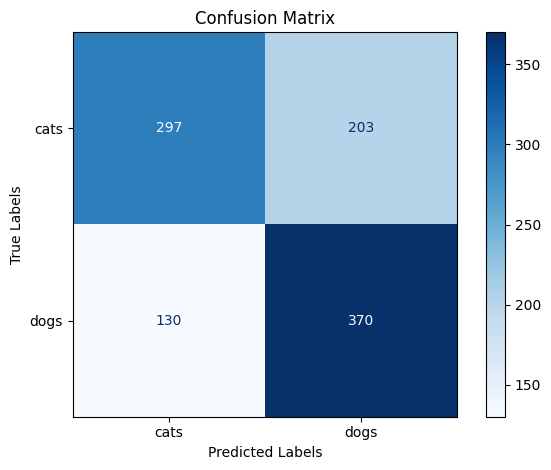

Global metrics:
FP: 333
FN: 333
Accuracy: 0.5004

Per-class metrics:
Class: cats
  FP: 130
  FN: 203
  Accuracy: 0.4714
Class: dogs
  FP: 203
  FN: 130
  Accuracy: 0.5263


In [15]:
model_path = [res for res in results_dict['models_paths'] if res.endswith('.keras')][0]

global_metric, metric_per_class = evaluate_model(
    model_path, 
    test_gen=test_gen,
    output_dir=current_output_dir,
    conf_matrix=True
)
print("Global metrics:")
print("FP:", global_metric.getFP())
print("FN:", global_metric.getFN())
print("Accuracy:", f"{global_metric.getAccuracy():.4f}")

print("\nPer-class metrics:")
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print("  FP:", metric_per_class[idx].getFP())
    print("  FN:", metric_per_class[idx].getFN())
    print("  Accuracy:", f"{metric_per_class[idx].getAccuracy():.4f}")

INFO:tensorflow:Assets written to: /tmp/tmpmz9tijb7/assets
[2025-07-23 12:52:05] - tensorflow - INFO - Assets written to: /tmp/tmpmz9tijb7/assets
Saved artifact at '/tmp/tmpmz9tijb7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133258881851712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258010874400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258010872640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258012132624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258011897776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258011891264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258011890736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133258011885984: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/mark/anaconda3/envs/testlib/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1753267925.366904  564011 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753267925.366943  564011 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-23 12:52:05.367179: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmz9tijb7
2025-07-23 12:52:05.368067: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-23 12:52:05.368095: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpmz9tijb7
2025-07-23 12:52:05.374597: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-23 12:52:05.431256: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path

Quantized model saved at ./training_outputs/train_23-07-2025_12-49-02/./training_outputs/train_23-07-2025_12-49-02/golden_model_folder/quantize/tiny_model_quantized.tflite


Processing data: 100%|██████████| 32/32 [00:01<00:00, 26.23it/s, accuracy=0.499, fn=334, fp=334, tp=666]


Confusion matrix saved at ./training_outputs/train_23-07-2025_12-49-02/tflite_model_confusion_matrix.png


<Figure size 1000x700 with 0 Axes>

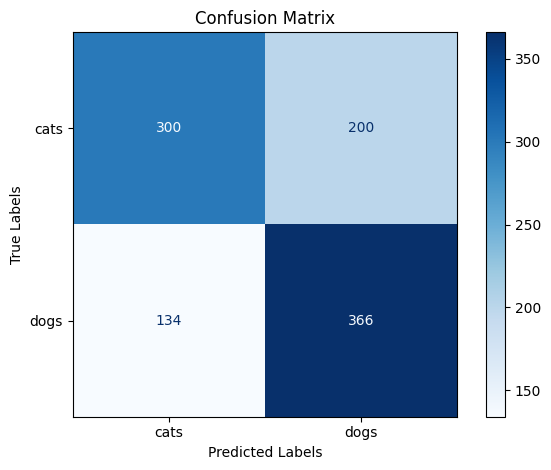

Global metrics:
FP: 334
FN: 334
Accuracy: 0.4993

Per-class metrics:
Class: cats
  FP: 134
  FN: 200
  Accuracy: 0.4732
Class: dogs
  FP: 200
  FN: 134
  Accuracy: 0.5229


In [17]:
from saltup.ai.utils.keras.quantization import quantize

model_path = [res for res in results_dict['models_paths'] if res.endswith('.keras')][0]

model_folder = os.path.dirname(model_path)
quantized_model_path = os.path.join(current_output_dir, model_folder, "quantize", f"{model_output_name}_quantized.tflite")

def representative_data_gen_fnct(datagenerator):
    for i in range(len(datagenerator)):
        images, _ = datagenerator[i]
        # If batch, yield each image separately for calibration
        if images.ndim == 4:
            for img in images:
                yield [img.astype(np.float32).reshape(1, *img.shape)]
        else:
            yield [images.astype(np.float32).reshape(1, *images.shape)]

# Pass the generator function itself, not its call
representative_data_gen = lambda: representative_data_gen_fnct(train_gen)
        

quantized_model_path = quantize(model_path, quantized_model_path, 
                           representative_data_gen, 
                           input_type = tf.uint8, 
                           output_type = tf.uint8)

global_metric, metric_per_class = evaluate_model(
    quantized_model_path, 
    test_gen=test_gen,
    output_dir=current_output_dir,
    conf_matrix=True
)
print("Global metrics:")
print("FP:", global_metric.getFP())
print("FN:", global_metric.getFN())
print("Accuracy:", f"{global_metric.getAccuracy():.4f}")

print("\nPer-class metrics:")
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print("  FP:", metric_per_class[idx].getFP())
    print("  FN:", metric_per_class[idx].getFN())
    print("  Accuracy:", f"{metric_per_class[idx].getAccuracy():.4f}")

In [ ]:
# Save the current notebook with the results. This is done at the end to ensure all outputs are captured.
save_current_notebook(current_output_dir)